In [80]:
import torch
from covid_ode import sidartha_ode, covid_dataset
import pandas as pd
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
canada = pd.read_csv('canada.csv')
canada = canada.values[:, 0:3].astype(float)

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
canada.shape

(555, 4)

In [7]:
canada

,Confirmed,Recovered,Deaths,Last_Update
0,4.0,0.0,0.0,2020-01-28 23:00:00
1,4.0,0.0,0.0,2020-01-29 19:30:00
2,4.0,0.0,0.0,2020-01-30 16:00:00
3,4.0,0.0,0.0,2020-01-31 23:59:00
4,4.0,0.0,0.0,2020-02-01 18:12:00
...,...,...,...,...
550,1434967.0,1404107.0,26599.0,2021-08-01 04:21:50
551,1435347.0,1404244.0,26601.0,2021-08-02 04:21:36
552,1435683.0,1404327.0,26602.0,2021-08-03 04:21:39
553,1437713.0,1405529.0,26608.0,2021-08-04 04:21:25


In [9]:
TRAIN_IDX = int(canada.shape[0]*.5)
VAL_IDX = TRAIN_IDX + int(canada.shape[0]*.1)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(canada[:TRAIN_IDX])

MinMaxScaler()

In [10]:
canada_train = min_max_scaler.transform(canada[:TRAIN_IDX])
canada_val = min_max_scaler.transform(canada[TRAIN_IDX:VAL_IDX])
canada_test = min_max_scaler.transform(canada[VAL_IDX:])

In [11]:
# Learning Rate
lr = 0.01

# number of historic data points for fitting
input_steps = 1

# forecasting horizon
output_steps = 2

# number of epochs for training
num_epochs = 20000

In [12]:
VAL_IDX-TRAIN_IDX

55

In [13]:
training_data = covid_dataset.CovidDataset(canada_train, input_steps, output_steps)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False)

val_data = covid_dataset.CovidDataset(canada_val, input_steps, output_steps)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

test_data = covid_dataset.CovidDataset(canada_test, input_steps, output_steps)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [14]:
model = sidartha_ode.SIDARTHEOde(len_data = output_steps).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1000, gamma=0.9)
loss_fun = torch.nn.MSELoss()
min_loss = 1
validation_prediction = [] 

for data, y_exact in tqdm(train_dataloader):
    optimizer.zero_grad()    
    y_approx = model(I0=data[0,0,0], H0=data[0,0,1], E0=data[0,0,2])
    loss = loss_fun(y_approx[1:, 
                             [model.pos_dict['I'], model.pos_dict['H'], model.pos_dict['E']]], # I, H, E
                    y_exact.squeeze())    
    loss.backward()
    optimizer.step()
    scheduler.step()    
with torch.no_grad():
    for data, y_exact in tqdm(val_dataloader):
        y_approx = model(I0=data[0,0,0], H0=data[0,0,1], E0=data[0,0,2])
        validation_prediction.append(y_approx.numpy())
        loss = loss_fun(y_approx[1:, 
                             [model.pos_dict['I'], model.pos_dict['H'], model.pos_dict['E']]], # I, H, E
                    y_exact.squeeze())
        print(loss)

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

tensor(0.0003)
tensor(0.0003)
tensor(0.0004)
tensor(0.0003)
tensor(0.0004)
tensor(0.0005)
tensor(0.0005)
tensor(0.0005)
tensor(0.0006)
tensor(0.0007)
tensor(0.0007)
tensor(0.0009)
tensor(0.0011)
tensor(0.0013)
tensor(0.0014)
tensor(0.0017)
tensor(0.0020)
tensor(0.0022)
tensor(0.0025)
tensor(0.0029)
tensor(0.0034)
tensor(0.0035)
tensor(0.0040)
tensor(0.0049)
tensor(0.0056)
tensor(0.0065)
tensor(0.0076)
tensor(0.0088)
tensor(0.0094)
tensor(0.0108)
tensor(0.0132)
tensor(0.0147)
tensor(0.0168)
tensor(0.0195)
tensor(0.0229)
tensor(0.0254)
tensor(0.0288)
tensor(0.0340)
tensor(0.0382)
tensor(0.0427)
tensor(0.0487)
tensor(0.0561)
tensor(0.0607)
tensor(0.0676)
tensor(0.0804)
tensor(0.0888)
tensor(0.0997)
tensor(0.1146)
tensor(0.1306)
tensor(0.1428)
tensor(0.1576)
tensor(0.1801)


In [15]:
y_exact

tensor([[[2.2502, 2.2213, 1.4323],
         [2.2786, 2.2554, 1.4465]]])

In [16]:
y_approx[1:, [model.pos_dict['I'], model.pos_dict['H'], model.pos_dict['E']]]

tensor([[2.2530, 2.1904, 1.4341],
        [3.3165, 2.2070, 1.4335]])

In [17]:
data

tensor([[[2.2225, 2.1803, 1.4204]]])

In [18]:
y_approx

tensor([[0.3753, 0.3533, 0.3791, 0.3455, 0.1400, 2.2225, 1.4204, 2.1803],
        [0.9355, 0.5496, 0.2764, 0.6478, 0.2501, 2.2530, 1.4341, 2.1904],
        [2.6265, 0.7440, 0.2466, 0.9558, 0.3888, 3.3165, 1.4335, 2.2070]])

In [25]:
validation_prediction = np.array(validation_prediction)

In [28]:
validation_prediction.shape

(52, 3, 8)

In [29]:
# predict, confirmed, recovered, death
observerable=[validation_prediction[:, :, [model.pos_dict['I'], model.pos_dict['H'], model.pos_dict['E']]]]

canada_val

array([[1.00985912, 1.01024196, 1.00402553],
       [1.0205462 , 1.01946327, 1.00765832],
       [1.03457485, 1.03144692, 1.01050565],
       [1.05462003, 1.04953919, 1.01610211],
       [1.06675923, 1.06032447, 1.02022582],
       [1.08391291, 1.06852007, 1.02444772],
       [1.10433173, 1.08889227, 1.029946  ],
       [1.12229214, 1.09852489, 1.03456063],
       [1.13907217, 1.10838094, 1.03966618],
       [1.15983916, 1.12604667, 1.04536082],
       [1.17954466, 1.1420621 , 1.05144821],
       [1.19703802, 1.15178104, 1.05743741],
       [1.22035258, 1.17007642, 1.06489936],
       [1.24100493, 1.19026075, 1.06971036],
       [1.25919887, 1.20278264, 1.07589593],
       [1.27662854, 1.22087999, 1.08306333],
       [1.30133153, 1.24253688, 1.09032892],
       [1.32011141, 1.2636606 , 1.09680903],
       [1.34012687, 1.28513977, 1.10682376],
       [1.36142036, 1.30657323, 1.11399116],
       [1.38296011, 1.32913906, 1.1203731 ],
       [1.40346385, 1.34850585, 1.12704958],
       [1.

In [56]:
inversed_predict = [min_max_scaler.inverse_transform(i) for i in observerable[0]]

In [57]:
inversed_predict = np.array(inversed_predict)

In [83]:
inversed_predict.shape

(52, 3, 3)

In [60]:
predict_1_ahead = inversed_predict[:,1]
predict_2_ahead = inversed_predict[:,2]

In [63]:
predict_1_ahead[:,0]

array([232774.20633877, 235253.8317928 , 238512.07851951, 243174.25856274,
       246001.41175703, 250001.29696119, 254770.06011402, 258971.47090241,
       262902.55819544, 267775.49127144, 272407.4044686 , 276525.96441943,
       282024.81533578, 286905.17389926, 291211.96813128, 295344.3835366 ,
       301212.2881465 , 305681.9689846 , 310454.10694441, 315540.53552632,
       320695.9242542 , 325612.90196237, 330340.16136045, 337264.15735896,
       342829.64075945, 348628.46334228, 354664.33692363, 360721.99517226,
       366499.16971896, 372153.81109911, 380133.57566188, 386181.92380728,
       392839.89610319, 399685.20802676, 406859.5647196 , 413379.53435183,
       419650.54449764, 427938.93079697, 434600.24064198, 441390.55938071,
       448415.01861768, 455948.89393134, 462598.17605854, 469068.83699965,
       478328.22559934, 485234.68857765, 492672.53870938, 500756.76584792,
       508660.07836646, 515464.14925912, 522174.00677461, 530636.52884265])

In [67]:
true_value=min_max_scaler.inverse_transform(canada_val)

In [71]:
x[2:]

range(2, 52)

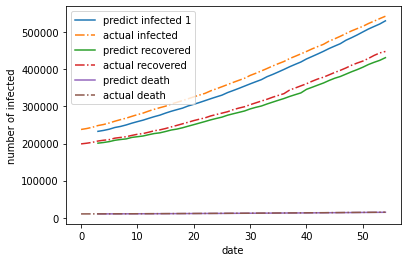

In [85]:
import matplotlib.pyplot as plt

x = range(len(true_value))

plt.plot(x[3:], predict_1_ahead[:,0], label ='predict infected 1')
plt.plot(x, true_value[:,0], '-.', label ='actual infected')
plt.plot(x[3:], predict_1_ahead[:,1], label ='predict recovered')
plt.plot(x, true_value[:,1], '-.', label ='actual recovered')

plt.xlabel("date")
plt.ylabel("number of people")
plt.legend()
plt.show()

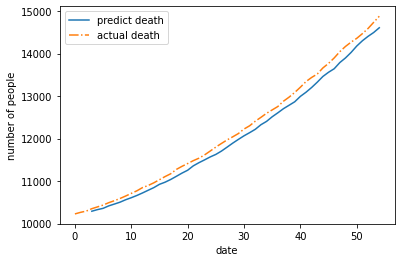

In [86]:
plt.plot(x[3:], predict_1_ahead[:,2], label ='predict death')
plt.plot(x, true_value[:,2], '-.', label ='actual death')
plt.xlabel("date")
plt.ylabel("number of people")
plt.legend()
plt.show()

In [84]:
mean_squared_error(predict_1_ahead[:,0], true_value[3:,0], squared=False)

19662.229484811858